In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [63]:
import pandas as pd

df = pd.concat(
    (
        pd.read_csv(f"numeric_features_{year}.csv").assign(year=year)
        for year in range(2012, 2025)
    ),
    ignore_index=True
)
df.loc[df['github_stars'].isna(), 'github_stars'] = 0

In [64]:
df.columns

Index(['num_revisions', 'primary_category', 'num_pages', 'upvote',
       'citing_models', 'citing_datasets', 'citing_spaces',
       'citing_collections', 'citationCount', 'citations', 'referenceCount',
       'influentialCitationCount', 'venue_type', 'venue_ranking',
       'citationCount_log', 'citations_log', 'num_authors', 'mean_citations',
       'max_citations', 'mean_h_index', 'max_h_index', 'mean_i10_index',
       'max_i10_index', 'slope_papers', 'slope_citations',
       'num_years_after_publication', 'mean_citations_over_years',
       'std_citations_over_years', 'year', 'github_stars'],
      dtype='object')

In [65]:
TRAIN_END = 2019
TEST_START = 2020

train_df = df[df['year'] <= TRAIN_END]
test_df  = df[df['year'] >= TEST_START]

target = 'citations_log'
features = df.columns.drop([target, 'year', 'citationCount', 'citations'])

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
scale_y_test = test_df[target]
y_test = test_df['citations']

In [66]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [68]:
rf_model = RandomForestRegressor(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
xgb_model = XGBRegressor(
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


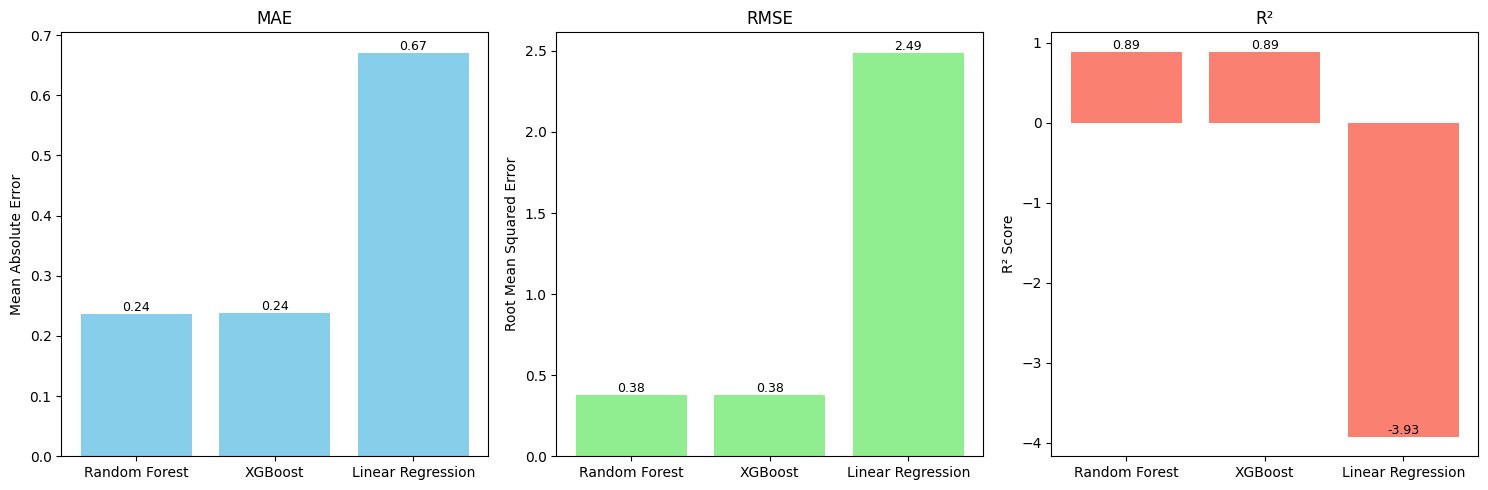

In [70]:
# Compute metrics
metrics = {"Model": [], "MAE": [], "RMSE": [], "R2": []}

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Linear Regression": lr_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(scale_y_test, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(scale_y_test, y_pred)))
    metrics["R2"].append(r2_score(scale_y_test, y_pred))

# Convert to arrays for plotting
model_names = metrics["Model"]
mae_values = metrics["MAE"]
rmse_values = metrics["RMSE"]
r2_values = metrics["R2"]

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(model_names, mae_values, color="skyblue")
axes[0].set_title("MAE")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(model_names, rmse_values, color="lightgreen")
axes[1].set_title("RMSE")
axes[1].set_ylabel("Root Mean Squared Error")

axes[2].bar(model_names, r2_values, color="salmon")
axes[2].set_title("R²")
axes[2].set_ylabel("R² Score")

for ax in axes:
    # ax.set_xticklabels(model_names, rotation=20, ha="right")
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), f"{v.get_height():.2f}", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

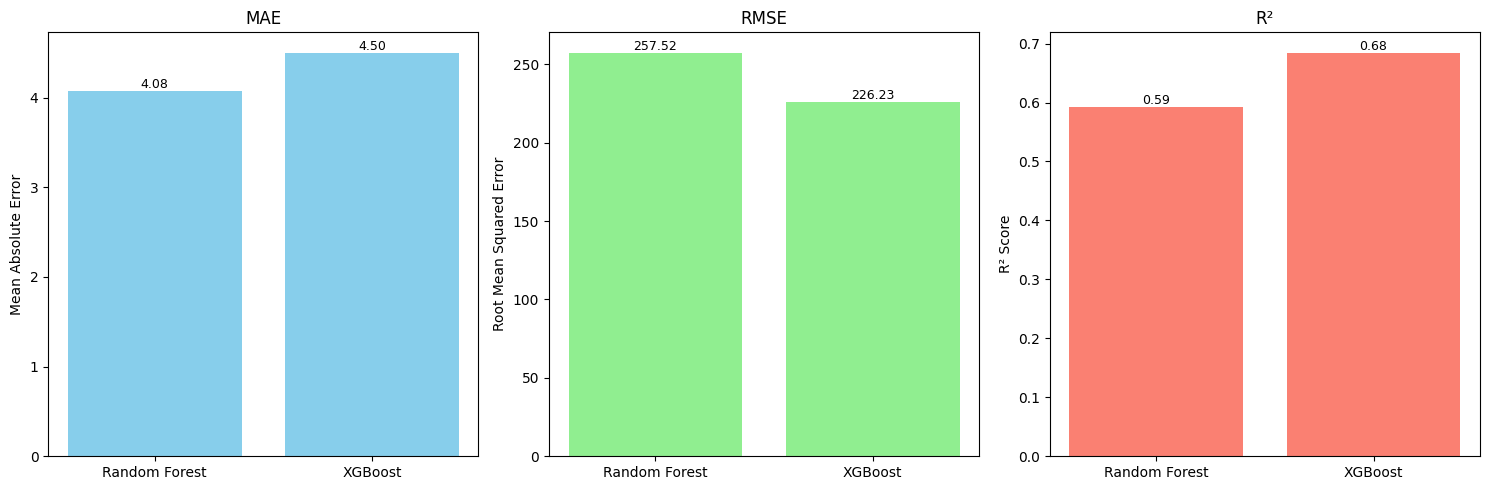

In [71]:
# Compute metrics
metrics = {"Model": [], "MAE": [], "RMSE": [], "R2": []}

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    # "Linear Regression": lr_model
}

for name, model in models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(y_test, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics["R2"].append(r2_score(y_test, y_pred))

# Convert to arrays for plotting
model_names = metrics["Model"]
mae_values = metrics["MAE"]
rmse_values = metrics["RMSE"]
r2_values = metrics["R2"]

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(model_names, mae_values, color="skyblue")
axes[0].set_title("MAE")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(model_names, rmse_values, color="lightgreen")
axes[1].set_title("RMSE")
axes[1].set_ylabel("Root Mean Squared Error")

axes[2].bar(model_names, r2_values, color="salmon")
axes[2].set_title("R²")
axes[2].set_ylabel("R² Score")

for ax in axes:
    # ax.set_xticklabels(model_names, rotation=20, ha="right")
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), f"{v.get_height():.2f}", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### With Text Feature

In [82]:
import pandas as pd

df = pd.concat(
    (
        pd.read_csv(f"features_{year}.csv").assign(year=year)
        for year in range(2012, 2025)
    ),
    ignore_index=True
)
df['arxiv_id'].astype(str)
df.loc[df['github_stars'].isna(), 'github_stars'] = 0

In [83]:
TRAIN_END = 2019
TEST_START = 2020

train_df = df[df['year'] <= TRAIN_END]
test_df  = df[df['year'] >= TEST_START]

train_tfidf_df = pd.read_csv("train_tfidf.csv")
test_tfidf_df = pd.read_csv("test_tfidf.csv")

train_df = train_df.merge(train_tfidf_df, how="left", on=['arxiv_id','year'])
test_df = test_df.merge(test_tfidf_df, how="left", on=['arxiv_id', 'year'])

drop_features = ['arxiv_id', 'year']
train_df.drop(drop_features, axis=1, inplace=True)
test_df.drop(drop_features, axis=1, inplace=True)

In [84]:
train_df = train_df.select_dtypes(include=["number"])
test_df = test_df.select_dtypes(include=["number"])
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [85]:
target = 'citations_log'
drop_features = [target, 'citationCount', 'citations']
features = train_df.columns.drop(drop_features)

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
scale_y_test = test_df[target]
y_test = test_df['citations']

In [86]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [88]:
rf_model = RandomForestRegressor(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
xgb_model = XGBRegressor(
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


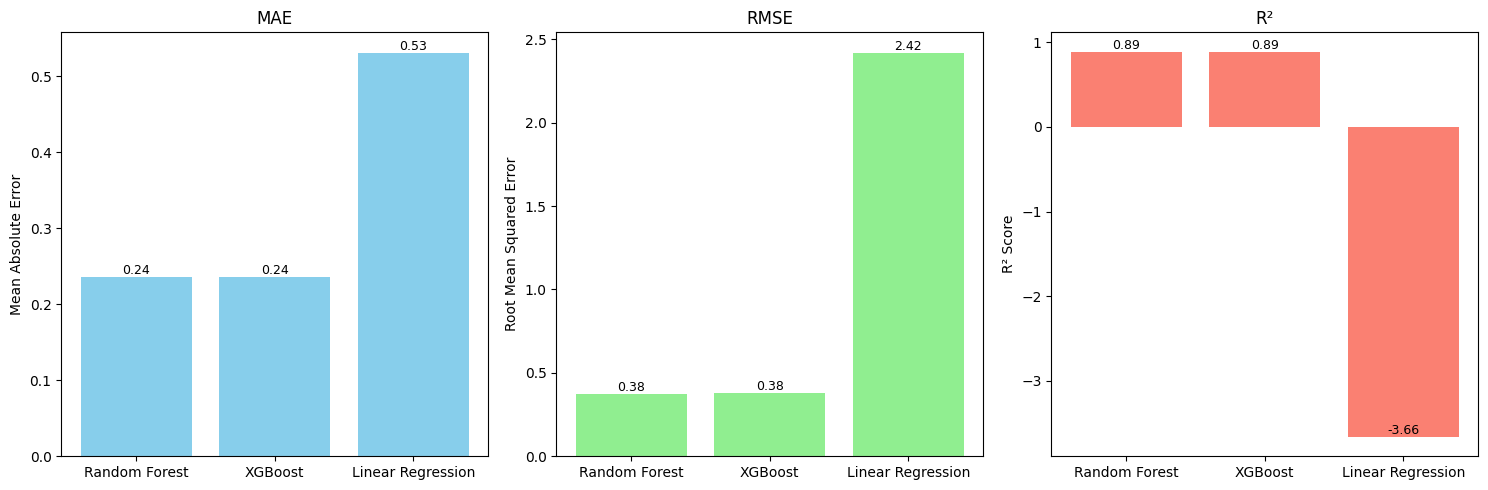

In [90]:
# Compute metrics
metrics = {"Model": [], "MAE": [], "RMSE": [], "R2": []}

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Linear Regression": lr_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(scale_y_test, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(scale_y_test, y_pred)))
    metrics["R2"].append(r2_score(scale_y_test, y_pred))

# Convert to arrays for plotting
model_names = metrics["Model"]
mae_values = metrics["MAE"]
rmse_values = metrics["RMSE"]
r2_values = metrics["R2"]

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(model_names, mae_values, color="skyblue")
axes[0].set_title("MAE")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(model_names, rmse_values, color="lightgreen")
axes[1].set_title("RMSE")
axes[1].set_ylabel("Root Mean Squared Error")

axes[2].bar(model_names, r2_values, color="salmon")
axes[2].set_title("R²")
axes[2].set_ylabel("R² Score")

for ax in axes:
    # ax.set_xticklabels(model_names, rotation=20, ha="right")
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), f"{v.get_height():.2f}", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

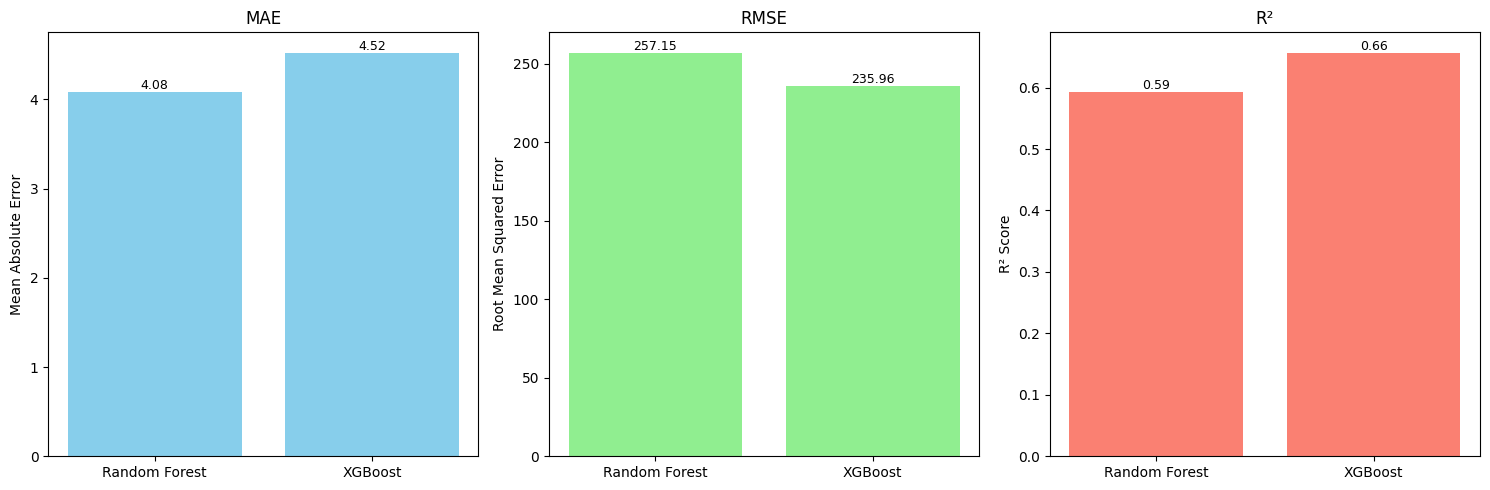

In [91]:
# Compute metrics
metrics = {"Model": [], "MAE": [], "RMSE": [], "R2": []}

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    # "Linear Regression": lr_model
}

for name, model in models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(y_test, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics["R2"].append(r2_score(y_test, y_pred))

# Convert to arrays for plotting
model_names = metrics["Model"]
mae_values = metrics["MAE"]
rmse_values = metrics["RMSE"]
r2_values = metrics["R2"]

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(model_names, mae_values, color="skyblue")
axes[0].set_title("MAE")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(model_names, rmse_values, color="lightgreen")
axes[1].set_title("RMSE")
axes[1].set_ylabel("Root Mean Squared Error")

axes[2].bar(model_names, r2_values, color="salmon")
axes[2].set_title("R²")
axes[2].set_ylabel("R² Score")

for ax in axes:
    # ax.set_xticklabels(model_names, rotation=20, ha="right")
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), f"{v.get_height():.2f}", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()